In [1]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
from qiskit.extensions import *
from qiskit import execute
from qiskit.providers.aer import noise, QasmSimulator, StatevectorSimulator, UnitarySimulator
from qiskit.providers.aer.noise import NoiseModel
import math
from random import *
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline

In [3]:
##Backends options

#takes as argument a circuit, a choice of backend (numbered), and a device name (str)
#if choice ==1, device name is irrelevant
def backend_choice(qc,choice,device_name):
    if choice == 1:
        ##simulator
        backend = Aer.get_backend('qasm_simulator')
        result = execute(qc,backend,shots=num).result()
        counts = result.get_counts()
        noise = 0
    if choice == 2:
        ##Using real machine as a backend
        provider = IBMQ.get_provider(hub='ibm-q-research')
        backend = provider.get_backend(device_name)
        device = provider.get_backend(device_name)
        result = execute(qc,backend,shots=num).result()
        counts = result.get_counts()
        noise=applyNoise(qc,device,backend)#returns noisy state counts data
    if choice == 3:
        ##Using real machines as noise model
        provider = IBMQ.get_provider(hub = 'ibm-q-research') 
        device = provider.get_backend(device_name) 
        result = execute(qc,device).result()
        counts=result.get_counts()
        noise=0
    return counts,noise

In [4]:
#hbar = 1

#Define coupling constant
def J(phi,A,B,C):
    result=(A*np.cos(phi)**2 + B*np.cos(phi)+C)
    return result

#create parts for weak coupling hamiltonian evolution
j=J(np.pi/4,0.5,0.5,0) #some default value for now
t=0.05 #hard-coded time for now
c=0.5*np.pi*j*t
e1=np.exp(-1j*np.abs(c))
e2=np.exp(1j*np.abs(c))
h_loc=[[e1,0],[0,e2]]
h_loc=np.array(h_loc)
Hj=UnitaryGate(h_loc)

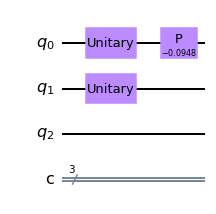

In [5]:
#testing H_j implementation. This circuit implements H_j

circ=QuantumCircuit(3,3)
circ.append(Hj,[0])
circ.append(Hj,[1])
circ.p(-2*c,0)
circ.draw()

In [6]:
#do the local hamiltonians
w1=0.2
w2=0.25
H1=np.array([[np.exp(1j*w1*t),0],[0,np.exp(-1j*w1*t)]])
H2=np.array([[np.exp(1j*w2*t),0],[0,np.exp(-1j*w2*t)]])
H1=UnitaryGate(H1)
H2=UnitaryGate(H2)

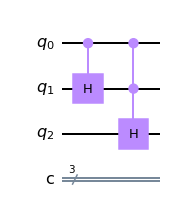

In [7]:
#Make a controlled hadamard and a controlled, controlled hadamard
chad=HGate().control(1)
cchad=HGate().control(2)
circ=QuantumCircuit(3,3)
circ.append(chad,[0,1])
circ.append(cchad,[0,1,2])
circ.draw()

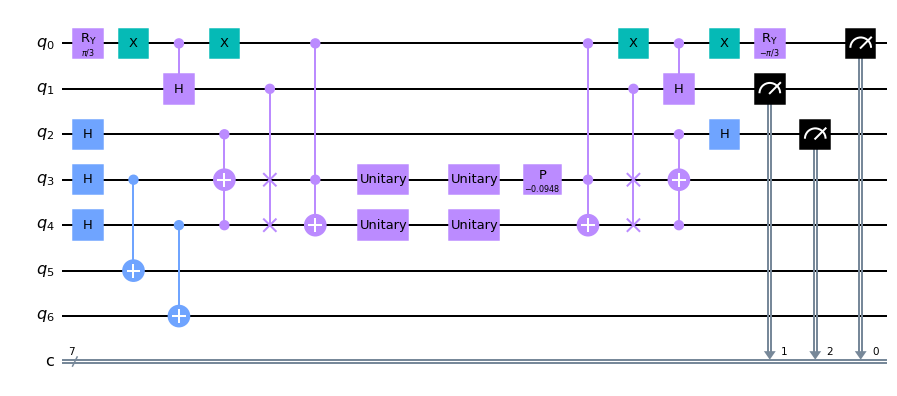

In [8]:
#dihedral circuit test. This is the asymmetric group case
circ2=QuantumCircuit(7,7)
circ2.ry(np.pi/3,0)
circ2.x(0)
circ2.append(chad,[0,1])
circ2.x(0)
circ2.h(2)
###manipulate the state under test here###
circ2.h(3)
circ2.h(4)
circ2.cnot(3,5)
circ2.cnot(4,6)
###back to circuit######
circ2.toffoli(2,4,3)
circ2.cswap(1,3,4)
circ2.toffoli(0,3,4)


###Hamiltonian here###
circ2.append(H1,[3])
circ2.append(H2,[4])
circ2.append(Hj,[3])
circ2.append(Hj,[4])
circ2.p(-2*c,3)

###other test###
circ2.toffoli(0,3,4)
circ2.cswap(1,3,4)
circ2.toffoli(2,4,3)


circ2.x(0)
circ2.append(chad,[0,1])
circ2.x(0)
circ2.ry(-1*np.pi/3,0)
circ2.h(2)

##measure##
circ2.measure(0,0)
circ2.measure(1,1)
circ2.measure(2,2)
circ2.draw()

In [9]:
#Parameterized dihedral test so that time-based data can be extracted. This one is for simulation
def dihedral_param(w1,w2,phi,a,b,t):
    H1=np.array([[np.exp(1j*w1*t),0],[0,np.exp(-1j*w1*t)]])
    H2=np.array([[np.exp(1j*w2*t),0],[0,np.exp(-1j*w2*t)]])
    H1=UnitaryGate(H1)
    H2=UnitaryGate(H2)
    j=J(phi,a,b,0) #some default value for now
    #t=0.05 #hard-coded time for now
    c=0.5*np.pi*j*t
    e1=np.exp(-1j*np.abs(c))
    e2=np.exp(1j*np.abs(c))
    h_loc=[[e1,0],[0,e2]]
    h_loc=np.array(h_loc)
    Hj=UnitaryGate(h_loc)
    circ2=QuantumCircuit(7,7)
    circ2.ry(np.pi/3,0)
    circ2.x(0)
    circ2.append(chad,[0,1])
    circ2.x(0)
    circ2.h(2)
    ###manipulate the state under test here###
    circ2.h(3)
    circ2.h(4)
    circ2.cnot(3,5)
    circ2.cnot(4,6)
    ###back to circuit######
    circ2.toffoli(2,4,3)
    circ2.cswap(1,3,4)
    circ2.toffoli(0,3,4)
    ###Hamiltonian here###
    circ2.append(H1,[3])
    circ2.append(H2,[4])
    circ2.append(Hj,[3])
    circ2.append(Hj,[4])
    circ2.p(-2*c,3)

    ###other test###
    circ2.toffoli(2,4,3)
    circ2.cswap(1,3,4)
    circ2.toffoli(0,3,4)
    circ2.x(0)
    circ2.append(chad,[0,1])
    circ2.x(0)
    circ2.ry(-1*np.pi/3,0)
    circ2.h(2)

    ##measure##
    circ2.measure(0,0)
    circ2.measure(1,1)
    circ2.measure(2,2)
    (counts,noise)=backend_choice(circ2,1,'ibm_lagos') ##change the second parameter to 3 to get real data
    p=counts["0000000"]/num
    return p

In [10]:
#For some time range, gets data points for that time
def get_time_data(a,b,phi,w1,w2,num=1024):
    t_list=[]
    #num=1024
    data=[]
    for i in range(1,100):
        t=i/100
        results=dihedral_param(w1,w2,phi,a,b,t)
        t_list.append(t)
        data.append(results)
    return t_list,data

Text(0, 0.5, 'Acceptance Probability')

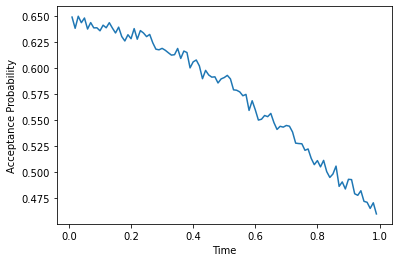

In [11]:
#simulated asymmetry
num=10000
results_list=get_time_data(0.5,0.5,np.pi/4,0.001,0.005,num)
plt.plot(results_list[0],results_list[1])
plt.xlabel('Time')
plt.ylabel('Acceptance Probability')

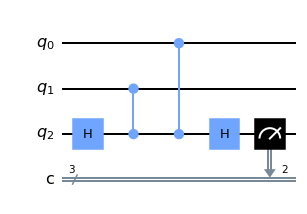

In [12]:
#Z symmetry
#circ2.unitary(UnitaryW,1)
circ2=QuantumCircuit(3,3)
circ2.h(2)
circ2.cz(2,1)
circ2.cz(2,0)
circ2.h(2)
circ2.measure(2,2)
circ2.draw()

In [13]:
#Z2 x Z2 test
def z2z2parallel():
    circ2=QuantumCircuit(7,7)
    circ2.h(0)
    circ2.h(1)
    ###manipulate the state under test here###
    circ2.h(3)
    circ2.h(4)
    circ2.cnot(3,5)
    circ2.cnot(4,6)
    ###back to circuit######
    ###Hamiltonian here###
    circ2.append(H1,[5])
    circ2.append(H2,[6])
    circ2.append(Hj,[3])
    circ2.append(Hj,[4])
    circ2.p(-2*c,3)
    ###other test###
    circ2.cz(0,5)
    circ2.cz(1,6)
    circ2.cz(1,4)
    circ2.cz(0,3)
    circ2.h(0)
    circ2.h(1)
    ##measure##
    circ2.measure(0,0)
    circ2.measure(1,1)
    circ2.draw()
    return circ2
    #

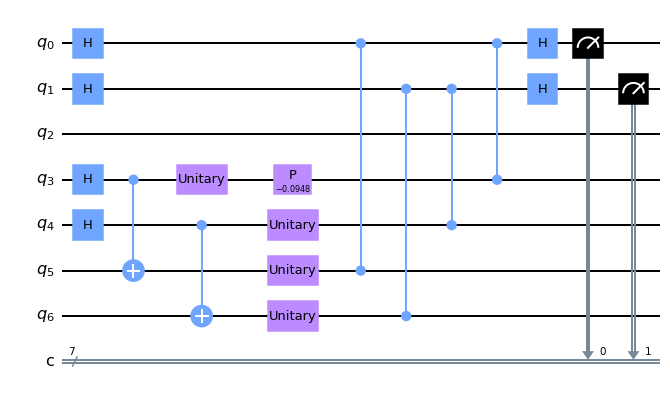

In [14]:
circuit=z2z2parallel()
circuit.draw()

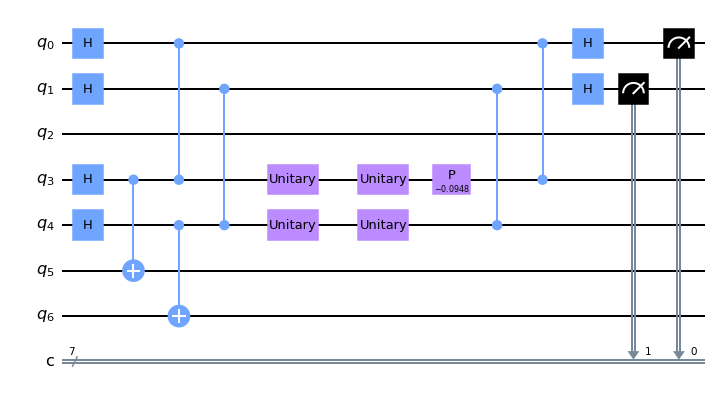

In [15]:
#Z2 x Z2 test
circ2=QuantumCircuit(7,7)
circ2.h(0)
circ2.h(1)
###manipulate the state under test here###
circ2.h(3)
circ2.h(4)
circ2.cnot(3,5)
circ2.cnot(4,6)
###back to circuit######
circ2.cz(1,4)
circ2.cz(0,3)
###Hamiltonian here###
circ2.append(H1,[3])
circ2.append(H2,[4])
circ2.append(Hj,[3])
circ2.append(Hj,[4])
circ2.p(-2*c,3)
###other test###
circ2.cz(1,4)
circ2.cz(0,3)
circ2.h(0)
circ2.h(1)
##measure##
circ2.measure(0,0)
circ2.measure(1,1)
circ2.draw()

In [16]:
#Parameterized z2 x z2 test allows time to change. Used for simulations
def z2z2_param(w1,w2,phi,a,b,t):
    H1=np.array([[np.exp(1j*w1*t),0],[0,np.exp(-1j*w1*t)]])
    H2=np.array([[np.exp(1j*w2*t),0],[0,np.exp(-1j*w2*t)]])
    H1=UnitaryGate(H1)
    H2=UnitaryGate(H2)
    j=J(phi,a,b,0) #some default value for now
    #t=0.05 #hard-coded time for now
    c=0.5*np.pi*j*t
    e1=np.exp(-1j*np.abs(c))
    e2=np.exp(1j*np.abs(c))
    h_loc=[[e1,0],[0,e2]]
    h_loc=np.array(h_loc)
    Hj=UnitaryGate(h_loc)
    circ2=QuantumCircuit(7,7)
    circ2.h(0)
    circ2.h(1)
    ###manipulate the state under test here###
    circ2.h(3)
    circ2.h(4)
    circ2.cnot(3,5)
    circ2.cnot(4,6)
    ###back to circuit######
    circ2.cz(1,4)
    circ2.cz(0,3)
    ###Hamiltonian here###
    circ2.append(H1,[3])
    circ2.append(H2,[4])
    circ2.append(Hj,[3])
    circ2.append(Hj,[4])
    circ2.p(-2*c,3)
    ###other test###
    circ2.cz(1,4)
    circ2.cz(0,3)
    circ2.h(0)
    circ2.h(1)
    circ2.measure(0,0)
    circ2.measure(1,1)
    (counts,noise)=backend_choice(circ2,1,'ibm_perth') #change second input to 3 to get real data
    p=counts["0000000"]/num
    return p

In [17]:
num=1024 #I just run this if things aren't working for some reason and it usually fixes things

In [18]:
#Simulates the symmetric case
def get_time_data_z2(a,b,phi,w1,w2,num=1024):
    t_list=[]
    data=[]
    for i in range(1,100):
        t=i/100
        results=z2z2_param(w1,w2,phi,a,b,t)
        t_list.append(t)
        data.append(results)
    return t_list,data

Text(0, 0.5, 'Acceptance Probability')

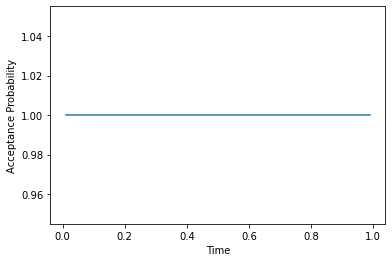

In [19]:
results_list2=get_time_data_z2(0.5,0.5,np.pi/4,0.001,0.005,num)
plt.plot(results_list2[0],results_list2[1])
plt.xlabel('Time')
plt.ylabel('Acceptance Probability')

In [22]:
#I compiled data and error analysis in an excel notebook to avoid timeouts on IBM Quantum, and so hard code them in for plot generation
lagos_prob=[0.887625, 0.886208333, 0.88575, 0.884995833, 0.881125, 0.888333333, 0.886916667, 0.883916667, 0.885791667, 0.875, 0.8773125, 0.8791875, 0.877625, 0.8749375, 0.876, 0.865125, 0.8771875, 0.8751875]
lagos_err=[0.002038417, 0.002049175, 0.002050623, 0.002056012, 0.002087733, 0.002031369, 0.002043538, 0.002065457, 0.002052414, 0.00261059, 0.002592606, 0.002565295, 0.002589563, 0.002610619, 0.002601268, 0.002689439, 0.002592566, 0.002611544]


In [20]:
#Just convenient definitions for plotting
symm_prob=results_list2[1]
asymm_time=results_list[0]
asymm_prob=results_list[1]

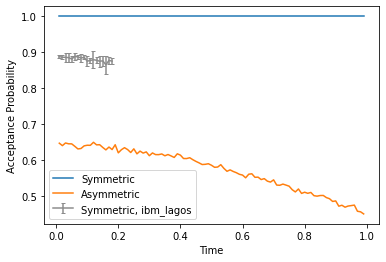

In [40]:
plt.figure()
plt.plot(results_list2[0],results_list2[1],label="Symmetric")
plt.plot(results_list[0],results_list[1],label="Asymmetric")
plt.errorbar(symm_time[0:18], lagos_prob, yerr=lagos_err, fmt='', capsize=2, label="Symmetric, ibm_lagos",c=".55")
plt.xlabel('Time')
plt.ylabel('Acceptance Probability')
plt.legend()
#Full time plot--real time data too small

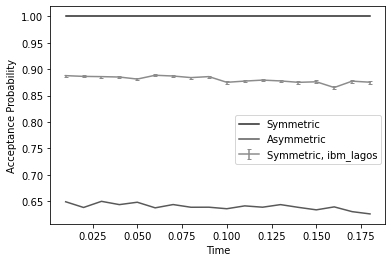

In [23]:
plt.figure()
plt.plot(symm_time[0:18],symm_prob[0:18],label="Symmetric", c="0.15")
plt.plot(asymm_time[0:18],asymm_prob[0:18],label="Asymmetric", c="0.35")
plt.errorbar(symm_time[0:18], lagos_prob, yerr=lagos_err, fmt='', capsize=2, label="Symmetric, ibm_lagos",c=".55")
plt.xlabel('Time')
plt.ylabel('Acceptance Probability')
#plt.ylim([0.5,1.01])
plt.legend(bbox_to_anchor=(0.55, 0.5), loc='upper left', borderaxespad=0)

In [21]:
#parameterized z2 x z2 again but gets real data for symmetric case
def z2z2_param_real(w1,w2,phi,a,b,t):
    H1=np.array([[np.exp(1j*w1*t),0],[0,np.exp(-1j*w1*t)]])
    H2=np.array([[np.exp(1j*w2*t),0],[0,np.exp(-1j*w2*t)]])
    H1=UnitaryGate(H1)
    H2=UnitaryGate(H2)
    j=J(phi,a,b,0) #some default value for now
    #t=0.05 #hard-coded time for now
    c=0.5*np.pi*j*t
    e1=np.exp(-1j*np.abs(c))
    e2=np.exp(1j*np.abs(c))
    h_loc=[[e1,0],[0,e2]]
    h_loc=np.array(h_loc)
    Hj=UnitaryGate(h_loc)
    circ2=QuantumCircuit(7,7)
    circ2.h(0)
    circ2.h(1)
    ###manipulate the state under test here###
    circ2.h(3)
    circ2.h(4)
    circ2.cnot(3,5)
    circ2.cnot(4,6)
    ###back to circuit######
    circ2.cz(1,4)
    circ2.cz(0,3)
    ###Hamiltonian here###
    circ2.append(H1,[3])
    circ2.append(H2,[4])
    circ2.append(Hj,[3])
    circ2.append(Hj,[4])
    circ2.p(-2*c,3)
    ###other test###
    circ2.cz(1,4)
    circ2.cz(0,3)
    circ2.h(0)
    circ2.h(1)
    circ2.measure(0,0)
    circ2.measure(1,1)
    (counts,noise)=backend_choice(circ2,3,'ibm_lagos')
    p=counts["0000000"]/num
    return p

def get_time_data_z2_real(a,b,phi,w1,w2,num=1024,t0=0):
    t_list=[]
    data=[]
    for i in range(1,10):
        t=t0 + i/100
        results=z2z2_param_real(w1,w2,phi,a,b,t)
        t_list.append(t)
        data.append(results)
    return t_list,data

In [ ]:
num=1024
results_list3=get_time_data_z2_real(0.5,0.5,np.pi/4,0.001,0.005)
plt.plot(results_list3[0],results_list3[1])
plt.xlabel('Time')
plt.ylabel('Acceptance Probability') #results begin after 8:33 PM March 16, on Lagos

Text(0, 0.5, 'Acceptance Probability')

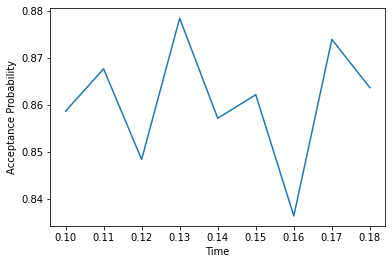

In [35]:
num=4000
results_list3=get_time_data_z2_real(0.5,0.5,np.pi/4,0.001,0.005, t0=0.09)
plt.plot(results_list3[0],results_list3[1])
plt.xlabel('Time')
plt.ylabel('Acceptance Probability') #results begin after 9 AM March 22, on lagos